In [1]:
import os
import numpy as np
import networkx as nx
from scipy.ndimage import gaussian_filter
from skimage import exposure

import matplotlib.pyplot as plt
from skimage import exposure
from scipy.ndimage import gaussian_filter

import process
import pandas

# Chip analysis

The following notebook is an analysis notebook. It has been conceived to order and analyse a dump of confocal images. All questions concerning the code should be emailed to gustave.ronteix@pasteur.fr.

These cells are to be used as fitting parameters for the cell

In [37]:
path = r'\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\01\06\cropStack'

livePosition = 2
green = 0
orange = 1

channels = [livePosition, green, orange]

zRatio = 1
r = 8
d = 20
pxtoum = 2/3

dX = 2*(int(r/pxtoum)//2)+1
dY = 2*(int(r/pxtoum)//2)+1
dZ = 2*(int(zRatio*r/pxtoum)//2)+1

rNoyau = (dZ, dX, dY)

dX = 2*(int(d/pxtoum)//2)+1
dY = 2*(int(d/pxtoum)//2)+1
dZ = 2*(int(zRatio*d/pxtoum)//2)+1

dCells = (dZ, dX, dY)

minmass = 5000

In [8]:
import spheroid

Sph = spheroid.spheroid(path, '01', '04', zRatio, r, d,pxtoum, minmass)
    # Initialize spheroid

if len(channels) == 3: # Improve dependancy on channel number...

    Sph._loadImage(channels[0], 'NucImage') # Load live cells
    Sph._loadImage(channels[1], 'GreenImage') # Load green cells
    Sph._loadImage(channels[2], 'OrangeImage') # Load orange cells

else: print("Wrong number of color channels")

print('image made, starting nuclei ID')

image made, starting nuclei ID


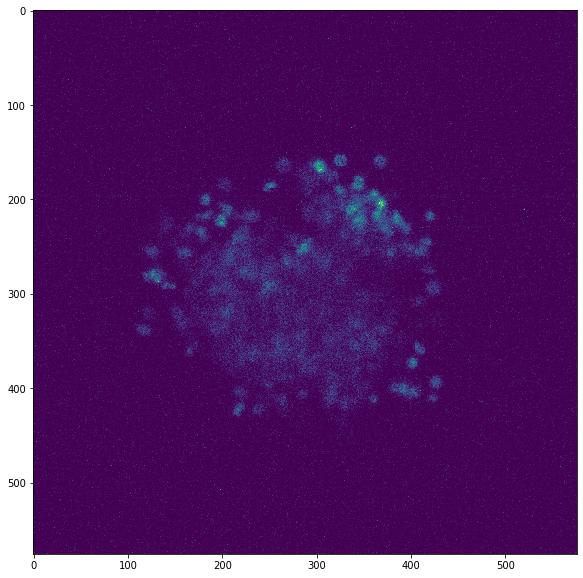

In [10]:
ax, fig = plt.subplots(figsize = (10,10))
plt.imshow(Sph.NucImage[45,:,:])

In [42]:
from trackpy import preprocessing
import trackpy

df = trackpy.locate(Sph.NucImage[:,:, :], rNoyau, minmass=None, maxsize=None, separation=None, noise_size=1, 
                    smoothing_size=None, threshold=None, invert=False, percentile=64, topn=300, 
                    preprocess=True, max_iterations=10, filter_before=None, filter_after=None, characterize=True, 
                    engine='numba')

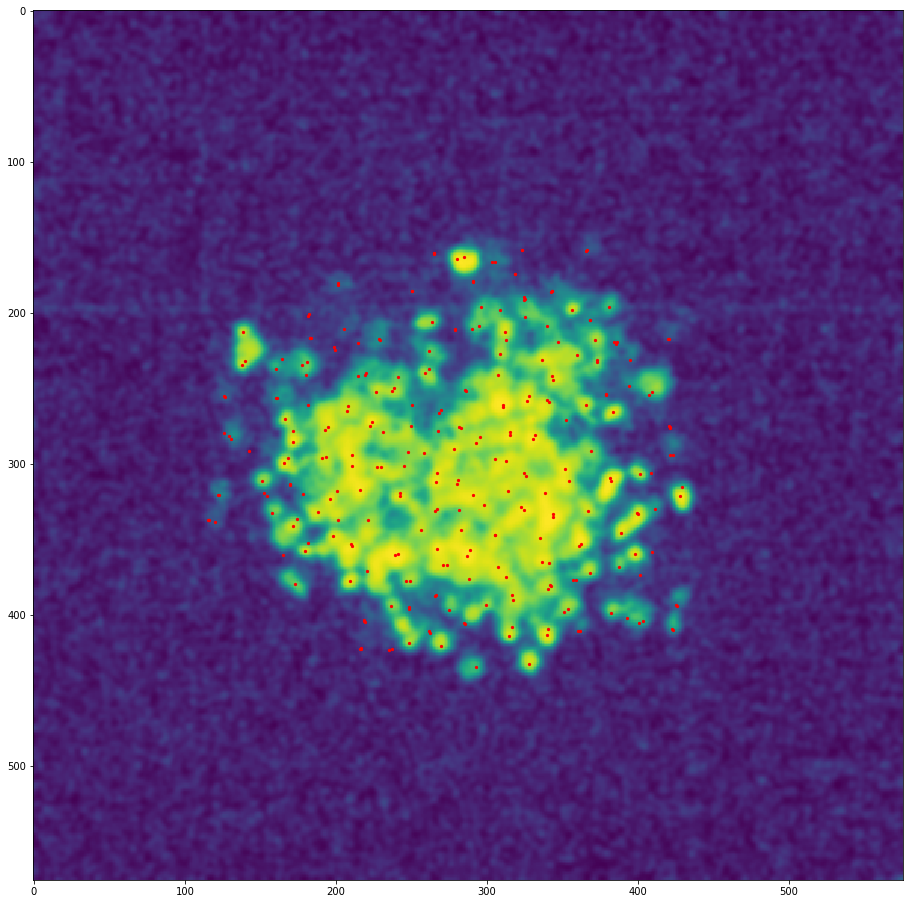

In [43]:
fd = df.loc[df['mass'] > minmass]

fd =fd.loc[((fd['x'] -fd['x'].mean())**2 < 4*fd['x'].std()**2) &
          ((fd['y'] -fd['y'].mean())**2 < 4*fd['y'].std()**2)]

img_eq = exposure.equalize_hist(Sph.NucImage[30])
im =  gaussian_filter(img_eq, sigma=2)

ax, fig = plt.subplots(figsize = (16,16))
plt.imshow(im)
plt.scatter(fd['x'], fd['y'], c = 'r', s = 5)

### Processing

The grunt functions are called from process.

Attention: verify the channel order.

In [44]:
path = r'\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix'
spheroidFolder = '1'
timeFolder = '2'

In [ ]:
process._sortFiles(path)

In [ ]:
process._makeSpheroidClass(path, zRatio, rNoyau, dCells, pxtoum, channels, minmass)

prep image: 01 folder and time 01
image made, starting nuclei ID
nuclei gotten, make spheroid
refine the analysis over the spheroid
refined the spheroid properties


Remarquons que la segmentation du spheroide dans un ou l'autre des types de cellules depend ici du classificateur naif que nous avons cree. Il repose sur un fit lineaire des points en fonction de leur couleur. On trouve que ce dernier doit avoir comme pente:

$a = \frac{<xy>}{<x^2>}$

Le signe par rapport a celui-ci est donne par:

$sign = y - a*x$

Ce qui nous donne par consequence un moyen rapide pour affecter un genre a chaque cellule.

In [ ]:
IntensityPath = r'\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\\'

In [ ]:
df1 = pandas.read_csv(IntensityPath + 'intensityFrame_5_19.csv')

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df1[['Green', 'Orange']]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

df1['Green Corr'] = X[:,0]
df1['Orange Corr'] = X[:,1]

In [ ]:
import matplotlib.pyplot as plt

ax1 = df1.plot.scatter(x='Orange Corr',y='Green Corr', c= 'r')

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

gmm =  mixture.GaussianMixture(n_components=2).fit(X)
labels = gmm.predict(X)

In [ ]:
from sklearn import mixture
gmm =  mixture.GaussianMixture(n_components=2).fit(X)
labels = gmm.predict(X)
fig, ax = plt.subplots(1, figsize=(7,7))
ax.scatter(df1['Orange Corr'],df1['Green Corr'],
          c=labels.astype(np.float), edgecolor="k", s=50)
ax.set_xlabel("Corrected Green")
ax.set_ylabel("Corrected Orange")
plt.title("Gaussian Mixture", fontsize=14)

## Checking the spheroid analysis

 - Get spheroid Data
 - Plot points
 - Plot segments
 - plot original image

In [ ]:
X = df1[['Green']]
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
km = KMeans(n_clusters=2)
km.fit(X)
km.predict(X)
labels = km.labels_
gmm =  mixture.GaussianMixture(n_components=2).fit(X)
labels = gmm.predict(X)

In [ ]:
fig, ax = plt.subplots(1, figsize=(7,7))
ax.scatter(df1['Orange Corr'],df1['Green Corr'],
          c=labels.astype(np.float), edgecolor="k", s=50)
ax.set_xlabel("Corrected Green")
ax.set_ylabel("Corrected Orange")
plt.title("Gaussian Mixture", fontsize=14)

In [ ]:
IntensityPath = r'\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\\'

import json

with open(IntensityPath + 'spheroid_3_19.json') as json_file:
    data = json.load(json_file)

In [ ]:
FigureFrame = pandas.DataFrame()
j = 0

for cell in data['cells'].keys():
    
    loc = data['cells'][cell]
    
    FigureFrame.loc[j, 'x'] = loc['x']
    FigureFrame.loc[j, 'y'] = loc['y']
    FigureFrame.loc[j, 'color'] = loc['state GMM']
    
    j += 1

In [ ]:
FigureFrame['x'] = pandas.to_numeric(FigureFrame['x'])
FigureFrame['y'] = pandas.to_numeric(FigureFrame['y'])
FigureFrame['label'] = (FigureFrame['color'] == 'Green').astype('int')

In [ ]:
plt.imshow(gaussian_filter(Sph.GreenImage[:,250:1750,750:2000],sigma=Sph.RNoyau)[45, :, :])

In [ ]:
img_eq = exposure.equalize_hist(Sph.OrangeImage[65,350:1750,200:2000])
im =  gaussian_filter(img_eq, sigma=4)

fig, ax = plt.subplots(figsize = (16,16))

for cell in data['cells'].keys():
    
    loc = data['cells'][cell]
    
    for neigh in loc['neighbours']:
        
        x1 = float(loc['x'])-200
        x2 = float(data['cells'][neigh]['x'])-200
        y1 = float(loc['y'])-350
        y2 = float(data['cells'][neigh]['y'])-350
        
        plt.plot([x1,x2], [y1,y2], 'r-', zorder = 1)
        
plt.imshow(im[:-250,:-250])
ax.scatter(FigureFrame['x']-200, FigureFrame['y']-350, c=FigureFrame['label'].astype(np.float), edgecolor="k", s=150, zorder=2)

### Modify the classification

We correct the classification by loading the .json file with the original intensities.


In [ ]:
import glob

In [ ]:
def default(o):
    if isinstance(o, np.int64): return int(o)
    raise TypeError

IntensityPath = r'\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\\'

import json

for fileName in glob.glob(IntensityPath + '*.json')[1:]:
    
    print(fileName)
    
    with open(fileName) as json_file:
        data = json.load(json_file)
        
    # Extract the intensities

    ClassFrame = pandas.DataFrame()
    j = 0

    for cell in data['cells'].keys():

        loc = data['cells'][cell]

        ClassFrame.loc[j, 'particle'] = cell
        ClassFrame.loc[j, 'Green'] = loc['Intensity Green']
        ClassFrame.loc[j, 'Orange'] = loc['Intensity Orange']

        j += 1

    X = ClassFrame[['Green']]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    gmm =  mixture.GaussianMixture(n_components=2).fit(X)
    labels = gmm.predict(X)

    ClassFrame['labels'] = labels
    
    a = ClassFrame.loc[ClassFrame['Green'] == ClassFrame['Green'].max(), 'labels'].iloc[0]
    
    if a < 0:
        
        ClassFrame['labels'] *= -1

    for part in ClassFrame['particle'].unique():

        data['cells'][str(part)]['state GMM postprocess'] = 2*ClassFrame.loc[ClassFrame['particle'] == part, 'labels'].iloc[0]-1
        
    with open(fileName, 'w') as fp:

        json.dump(data, fp, default = default)

In [ ]:
ClassFrame = pandas.DataFrame()
j = 0

for cell in data['cells'].keys():
    
    nCross = 0
    nSelf = 0

    loc = data['cells'][cell]
    si = loc['state GMM postprocess']
    
    for neigh in loc['neighbours']:
        sj = data['cells'][neigh]['state GMM postprocess']
        
        if sj*si < 0:
            
            nCross += 1
            
        if sj*si > 0 :
            
            nSelf += 1
            
    ClassFrame.loc[j, 'particle'] = cell
    ClassFrame.loc[j, 'state'] = si
    ClassFrame.loc[j, 'neighbours'] = nCross + nSelf
    ClassFrame.loc[j, 'cross link'] = nCross
    ClassFrame.loc[j, 'self link'] = nSelf
    j += 1

In [ ]:
IntensityPath = r'\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\\'

import json

ClassFrame = pandas.DataFrame()
j = 0

for fileName in glob.glob(IntensityPath + '*.json')[1:]:
    
    _, sph, time = fileName.split('_')
    time, _ = time.split('.')
    
    print(fileName)
    
    with open(fileName) as json_file:
        data = json.load(json_file)
        
    try:
        
        for cell in data['cells'].keys():

            nCross = 0
            nSelf = 0

            loc = data['cells'][cell]
        
        
            si = loc['state GMM postprocess']

            for neigh in loc['neighbours']:
                sj = data['cells'][neigh]['state GMM postprocess']

                if sj*si < 0:

                    nCross += 1

                if sj*si > 0 :

                    nSelf += 1

            ClassFrame.loc[j, 'time'] = time
            ClassFrame.loc[j, 'spheroid'] = sph
            ClassFrame.loc[j, 'particle'] = cell
            ClassFrame.loc[j, 'state'] = si
            ClassFrame.loc[j, 'neighbours'] = nCross + nSelf
            ClassFrame.loc[j, 'cross link'] = nCross
            ClassFrame.loc[j, 'self link'] = nSelf
            j += 1
            
    except: print(fileName)

In [ ]:
ResultFrame = pandas.DataFrame()
i = 0

for sph in ClassFrame['spheroid'].unique():
    for time in ClassFrame.loc[ClassFrame['spheroid'] == sph, 'time'].unique():
        
        locFrame = ClassFrame.loc[(ClassFrame['spheroid'] == sph) &
                                 (ClassFrame['time'] == time)]
        
        ResultFrame.loc[i, 'spheroid'] = sph
        ResultFrame.loc[i, 'time'] = int(time)
        ResultFrame.loc[i, 'degree'] = locFrame['neighbours'].mean()
        ResultFrame.loc[i, 'degree -1'] = locFrame.loc[locFrame['state'] == -1, 'neighbours'].mean()
        ResultFrame.loc[i, 'degree 1'] = locFrame.loc[locFrame['state'] == 1, 'neighbours'].mean()
        ResultFrame.loc[i, 'p(cross|s = 1)'] = locFrame.loc[locFrame['state'] == 1, 
                'cross link'].sum()/locFrame.loc[locFrame['state'] == 1, 'neighbours'].sum()
        ResultFrame.loc[i, 'p(cross|s = -1)'] = locFrame.loc[locFrame['state'] == -1, 
                'cross link'].sum()/locFrame.loc[locFrame['state'] == -1, 'neighbours'].sum()
        i += 1

In [ ]:
plt.figure()

for sph in ResultFrame['spheroid'].unique():
    
    locFrame = ResultFrame.loc[ResultFrame['spheroid'] == sph].sort_values('time')
    
    plt.plot(locFrame['time'], locFrame['p(cross|s = -1)'])

### Calculating a pseudo-energy

### Extracting features

### Refined analysis

We use the refined metrics of networkx to add centrality, degree and other measures to the death/survival rates of the spheroid. The following process follows:

 - open json file
 - modify the spheroid properties
 - save global properties in soheroid file
 - save file

In [ ]:
def _refineSph(dic):
    
    G = _makeG(dic)
    
    A = networkx.betweenness_centrality(G) # betweeness centrality
    B = networkx.clustering(G)
    C = networkx.degree(G)
    
    for v in G:
        
        dic['cells'][v]['degree'] = C[v]
        dic['cells'][v]['clustering'] = B[v]
        dic['cells'][v]['centrality'] = A[v]
        
    dic['N'] = len(dic['cells'])
    dic['assortativity'] = nx.degree_assortativity_coefficient(G)
    dic['average degree'] = np.asarray([float(C[v]) for v in G]).mean()
    
    return dic

In [ ]:
_refineSph(_Sph)

process._saveSpheroid(_Sph.Spheroid, path + '\spheroid_' + spheroidFolder + r'_' +  timeFolder + '.json')